# 순환 신경망으로 idmb 리뷰 분류하기

In [1]:
from tensorflow.keras.datasets import imdb
(train_input,train_target),(test_input,test_target) = imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 2s 0us/step


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [ ]:
print(len(train_input[0]))
# 첫 번째 리뷰는 길이가 218개인 토큰으로 이루어져있다

218


In [ ]:
print(len(train_input[1]))
# 길이는 리뷰마다 제각각

189


In [ ]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [2]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = \
train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [3]:
# 각 리뷰의 길이를 계산해 넘파이 배열에 담는다
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [ ]:
print(np.mean(lengths),np.median(lengths))
# 리뷰 길이는 한쪽에 치우쳐진 것으로 판단된다

239.00925 178.0


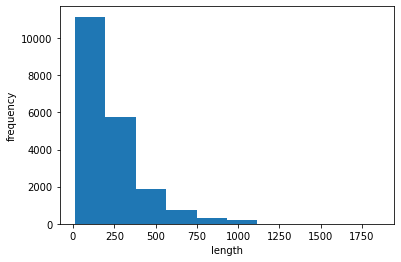

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths)
plt.xlabel("length") 
plt.ylabel("frequency")
plt.show()

In [4]:
# 시퀀스 테디어트이 길이를 맞추는 ped_sequences() 함수를 이용하여 train_input의 길이를 100으로 맞춘다
# ped_sequences()는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자른다
# 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되므로
# 마지막에 패딩을 추가하는것은 일반적으로 선호되지 않는다
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input,maxlen=100)

In [ ]:
print(train_input.shape, train_seq.shape)

(20000,) (20000, 100)


In [5]:
val_seq = pad_sequences(val_input,maxlen=100)

In [ ]:
print(val_input.shape, val_seq.shape)

(5000,) (5000, 100)


### 순환 신경망 만들기

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8,input_shape=(100,500)))
# 100은 사용할 뉴런의 개수로 샘플의 길이를 앞에서 100으로 지정하였기 때문
# 500은 imdb 데이터셋에서 500개 단어만 사용하였기에
# 원-핫 인코딩방식으로 숫자 500을 지정
model.add(keras.layers.Dense(1,activation="sigmoid"))
# 좋다, 안좋다의 이진 분류이기에 시그모이드 함수 적용
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 케라스에서 원-핫 인코딩용으로 제공하는 to_categorical()함수 이용
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
val_oh = keras.utils.to_categorical(val_seq)
print(val_oh.shape)

(5000, 100, 500)


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 22s 61ms/step - loss: 0.7010 - accuracy: 0.5051 - val_loss: 0.6977 - val_accuracy: 0.5084
Epoch 2/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6933 - accuracy: 0.5203 - val_loss: 0.6890 - val_accuracy: 0.5394
Epoch 3/100
313/313 [==============================] - 22s 69ms/step - loss: 0.6838 - accuracy: 0.5566 - val_loss: 0.6822 - val_accuracy: 0.5618
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6740 - accuracy: 0.5916 - val_loss: 0.6721 - val_accuracy: 0.5912
Epoch 5/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6613 - accuracy: 0.6207 - val_loss: 0.6585 - val_accuracy: 0.6296
Epoch 6/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6457 - accuracy: 0.6540 - val_loss: 0.6431 - val_accuracy: 0.6524
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6282 - accuracy: 0.6770 - val_loss: 0.6359 - val_ac

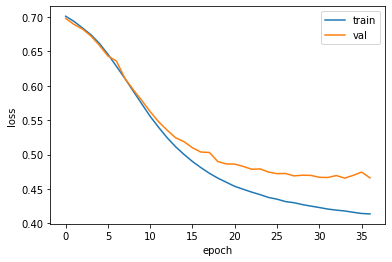

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
print(train_seq.nbytes, train_oh.nbytes)
# 원-핫 인코딩의 단점은 입력 데이터가 매우 커진다는것이 있다

8000000 4000000000


### 단어 임베딩  
순환 신경망에서 텍스트를 처리할 때 주로 사용하는 단어 표현 방법


In [7]:
from tensorflow import keras
# 단어 임베딩은각 단어를 고정된 크기의 실수 벡터로 바꾸어준다
# 원-핫 인코딩에서 더 좋은 성능을 내는 경우가 많다
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500,16,input_length=100))
# 두 번째 수 16은 임베딩 벡터의 크기
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1,activation="sigmoid"))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 200       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('./drive/MyDrive/개인 공부/ML_DL/data/best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 34ms/step - loss: 0.6910 - accuracy: 0.5246 - val_loss: 0.6924 - val_accuracy: 0.5162
Epoch 2/100
313/313 [==============================] - 13s 41ms/step - loss: 0.6882 - accuracy: 0.5398 - val_loss: 0.6913 - val_accuracy: 0.5218
Epoch 3/100
313/313 [==============================] - 10s 31ms/step - loss: 0.6854 - accuracy: 0.5515 - val_loss: 0.6905 - val_accuracy: 0.5260
Epoch 4/100
313/313 [==============================] - 9s 30ms/step - loss: 0.6824 - accuracy: 0.5627 - val_loss: 0.6900 - val_accuracy: 0.5254
Epoch 5/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6791 - accuracy: 0.5757 - val_loss: 0.6898 - val_accuracy: 0.5306
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6756 - accuracy: 0.5860 - val_loss: 0.6895 - val_accuracy: 0.5298
Epoch 7/100
313/313 [==============================] - 9s 27ms/step - loss: 0.6719 - accuracy: 0.5943 - val_loss: 0.6890 - val_accu

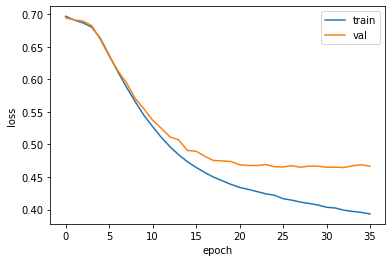

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()